In [2]:
#Imports
import numpy as np
import pandas as pd
from IPython.display import display
from matplotlib import pyplot as plt
import seaborn as sns
import sympy as sp

#Resolution for plots
dpi_val = 300

# 1. Runge's Phenomenon

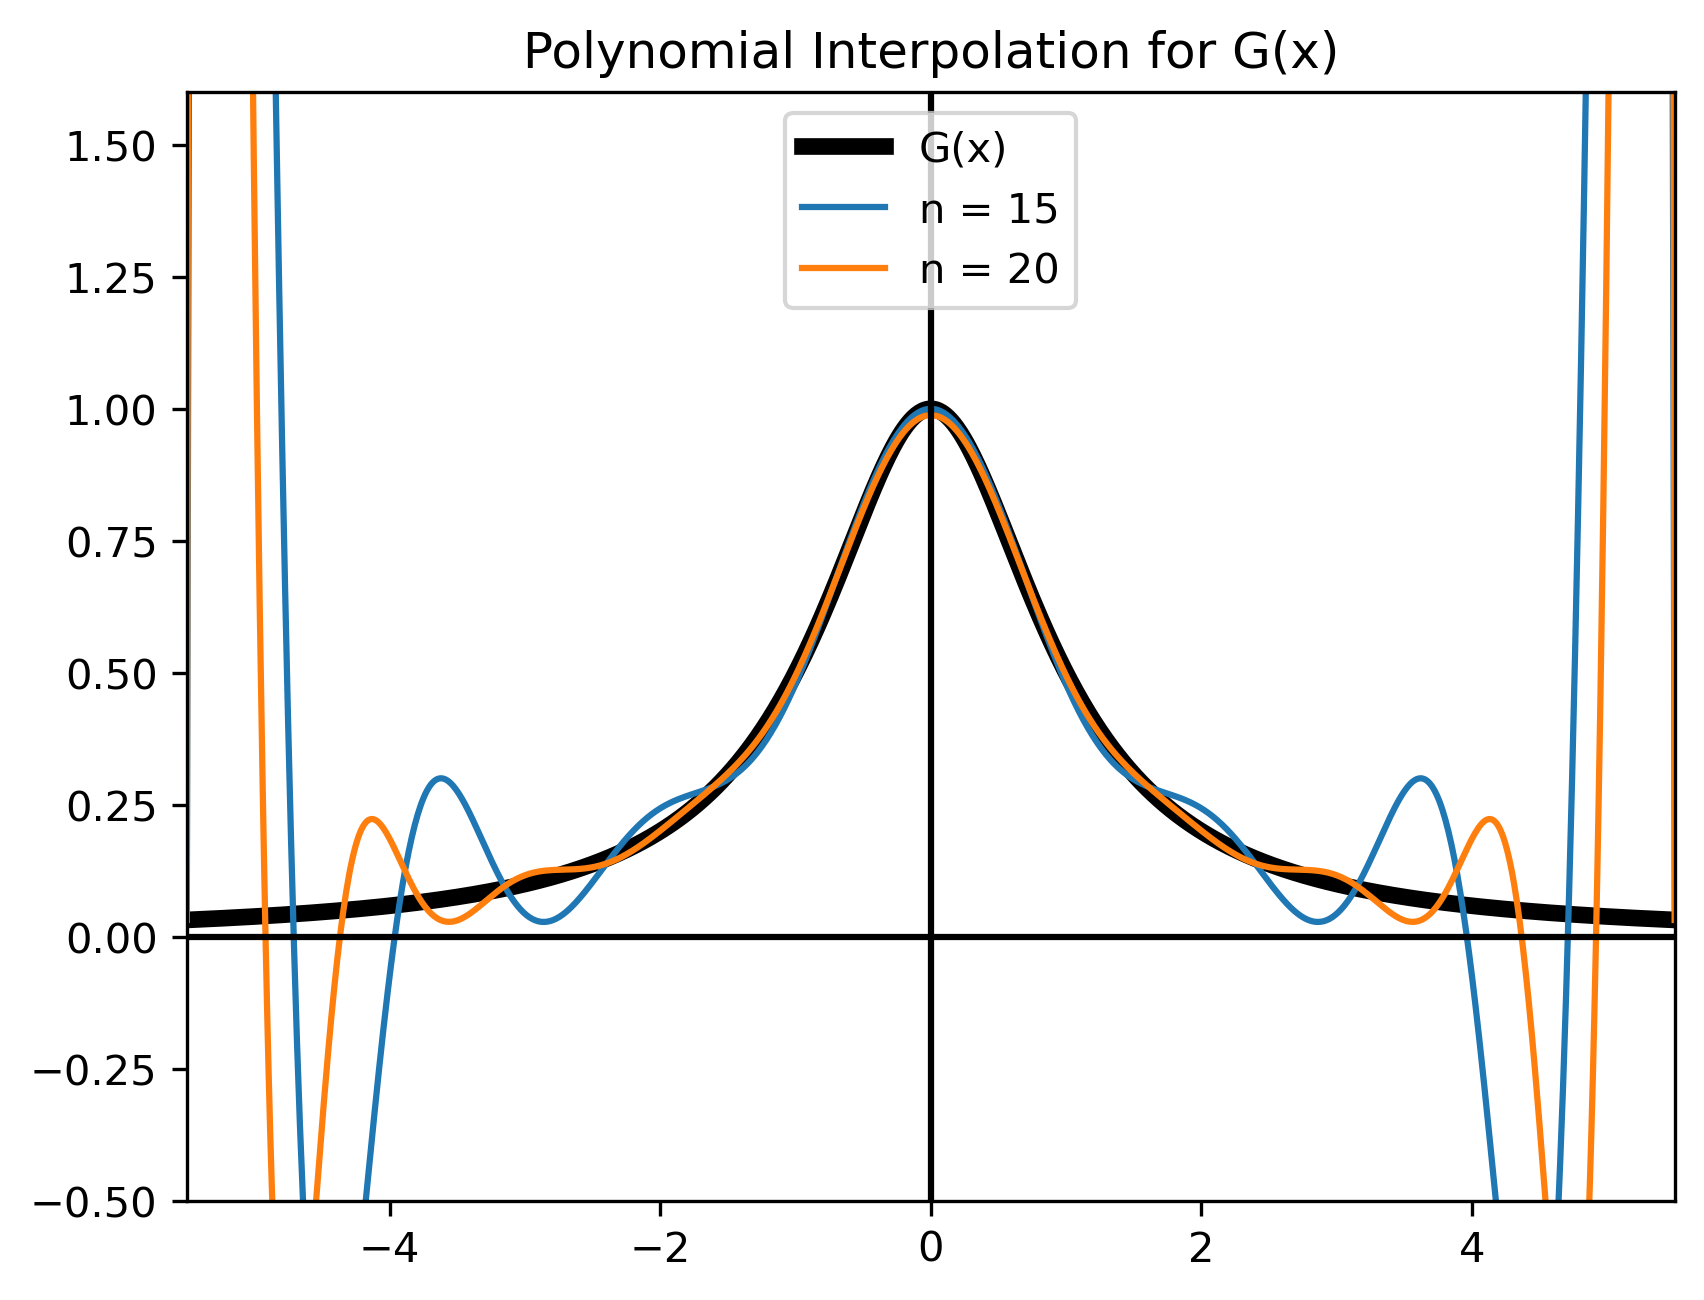

In [3]:
#The problematic function
def runge_func(x):
    return 1/(1+x**2)


def poly_interpolation(n: int, f, cheby: bool = False, a: int = -1, b: int = 1):
    """
    Calculates the lagrangian interpolation polynomial of the function f

    Inputs:
    n: Integer which denotes the number of points the polynomial must interpolate
    f: Function which we want to approximate with our polynomial
    cheby: If false we use evenly space points otherwise we use Chebyshev points
    a: The lower extreme of the interval we are interpolating over. Also the first interpolating point
    b: The upper extreme of the interval we are interpolating over. Also the last interpolating point

    Output:
    A function which returns the interpolating polynomial at a point x
    """
    #Data points
    if not cheby:
        #Evenly spaced points if cheby == False
        x_points = np.linspace(a,b,n)
    else:
        #Chebyshev points
        x_points = [(0.5 * (a + b) + 0.5 * (b - a) * np.cos((2*i + 1) * np.pi / (2 * n))) for i in range(n)]

    #The values of the function at the data points
    func = np.vectorize(f)
    y_points = func(x_points)

    #Interpolant polynomial as a function of x
    def interpolant(x):
        #Creating the lagrangian basis
        lagrange_basis = []
        for i in range(n):
            l_i = 1
            #One element of the lagrangian basis
            for j in range(n):
                if j != i:
                    l_i *= (x - x_points[j]) / (x_points[i] - x_points[j])                    
            lagrange_basis.append(l_i)   
        #The value of the interpolating polynomial at x
        return sum([y_points[k] * lagrange_basis[k] for k in range(n)])
    return np.vectorize(interpolant)

#The figure and some variables
fig, ax = plt.subplots(dpi=dpi_val)
ax.set_ylim([-0.5, 1.6])
ax.set_xlim([-5.5, 5.5])
a = -5
b = 5
extra = 0.5
lower = a - extra
upper = b + extra
res = 1000

#The real function  
exact_vals = [runge_func(t) for t in np.linspace(lower, upper, res)]
ax.plot(np.linspace(lower, upper, res), exact_vals, linewidth=4, color="black")   

#The Lagrangian polynomial interpolation for some values of n
for n in [15, 20]:
    n_th = poly_interpolation(n, runge_func, a = lower, b = upper)
    vals = [n_th(t) for t in np.linspace(lower, upper, res)]
    ax.plot(np.linspace(lower, upper, res), vals)

#x and y axis lines
plt.axhline(y=0, color='black', linestyle='-')
plt.axvline(x=0, color='black', linestyle='-')
ax.legend(["G(x)", "n = 15", "n = 20"], loc = "upper center")
plt.title("Polynomial Interpolation for G(x)")
plt.savefig("Images/runge phenomenon")
plt.show()

## 1.1 Same problem with the absolute value

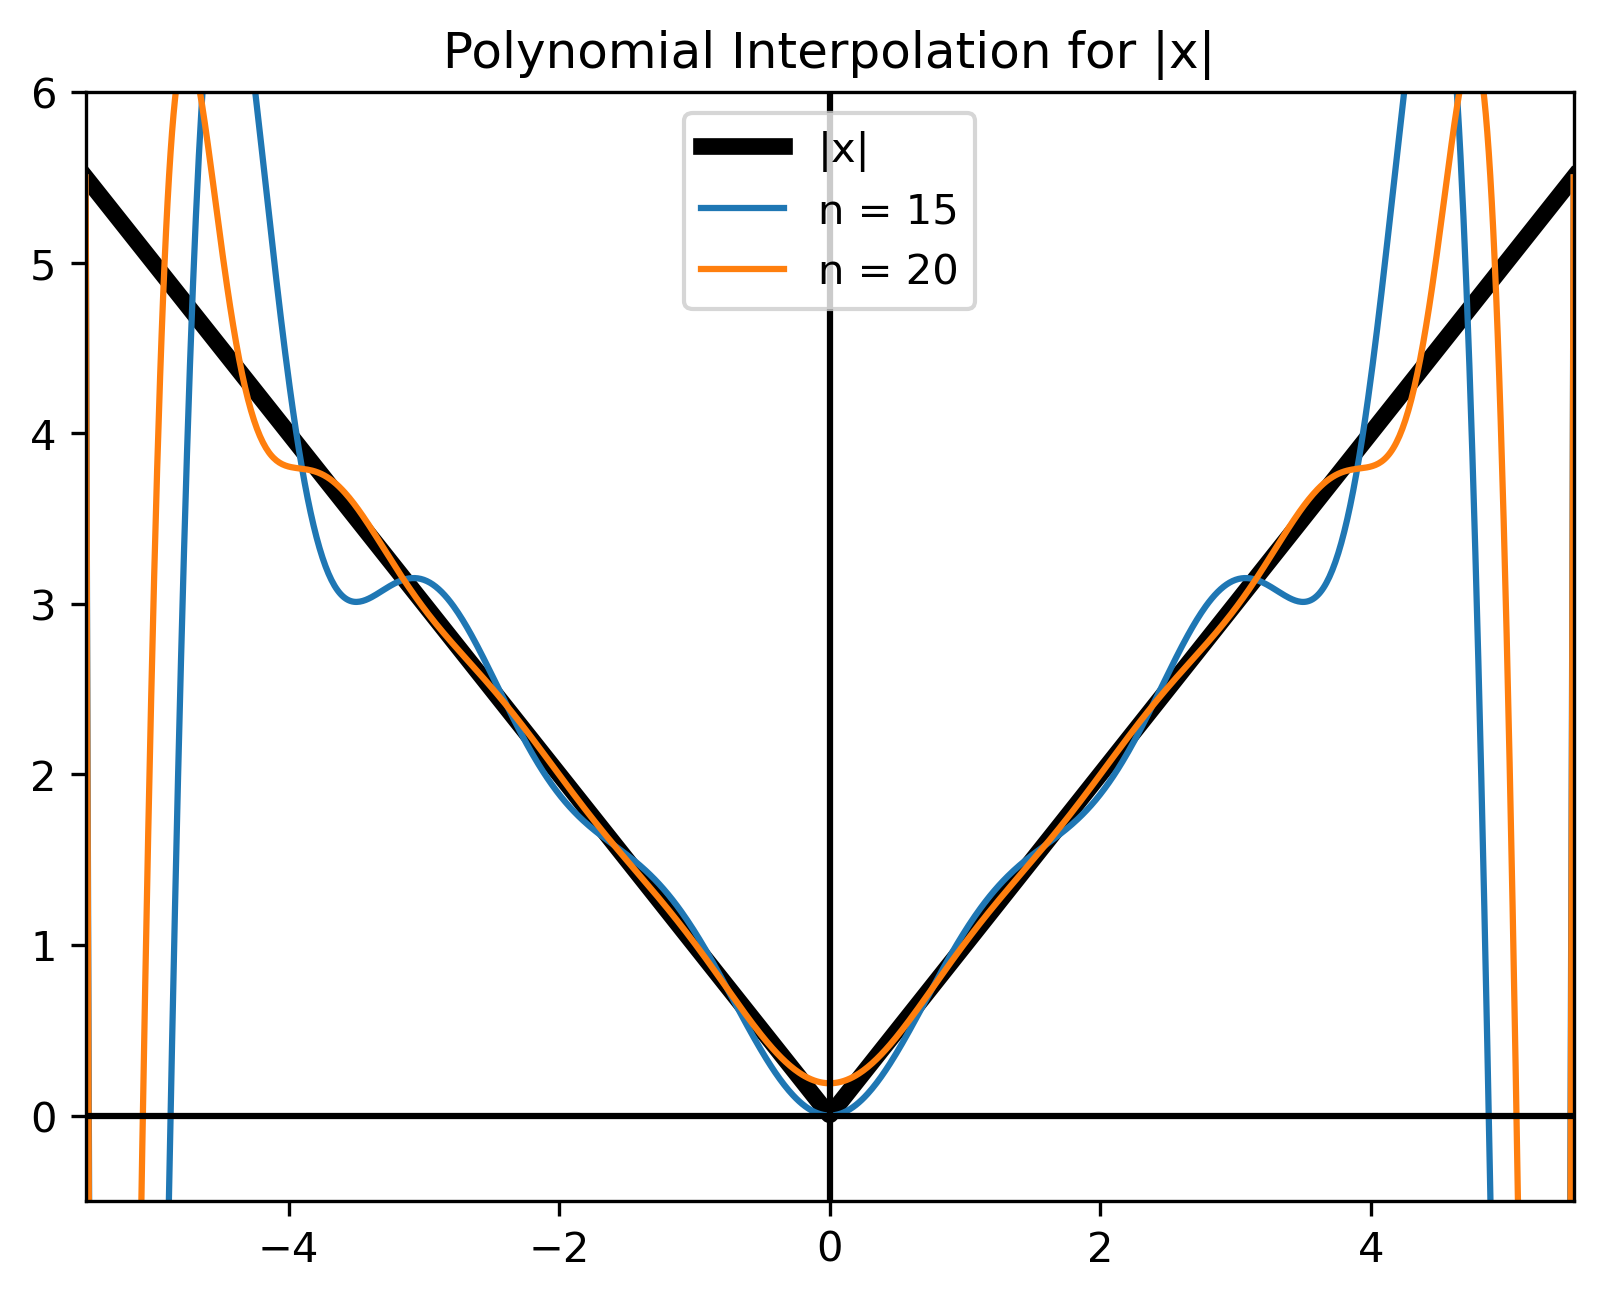

In [4]:
#The figure and some variables
fig, ax = plt.subplots(dpi=dpi_val)
ax.set_ylim([-0.5, 6])
ax.set_xlim([-5.5, 5.5])
a = -5
b = 5
extra = 0.5
lower = a - extra
upper = b + extra
res = 1000

#The real function  
exact_vals = [np.abs(t) for t in np.linspace(lower, upper, res)]
ax.plot(np.linspace(lower, upper, res), exact_vals, linewidth=4, color="black")   

#The Lagrangian polynomial interpolation for some values of n
for n in [15, 20]:
    n_th = poly_interpolation(n, np.abs, a = lower, b = upper)
    x = np.linspace(lower, upper, res)
    vals = n_th(x)
    ax.plot(x, vals)

#x and y axis lines
plt.axhline(y=0, color='black', linestyle='-')
plt.axvline(x=0, color='black', linestyle='-')
ax.legend(["|x|", "n = 15", "n = 20"])
plt.title("Polynomial Interpolation for |x|")
plt.show()

## 1.2 The Culprit

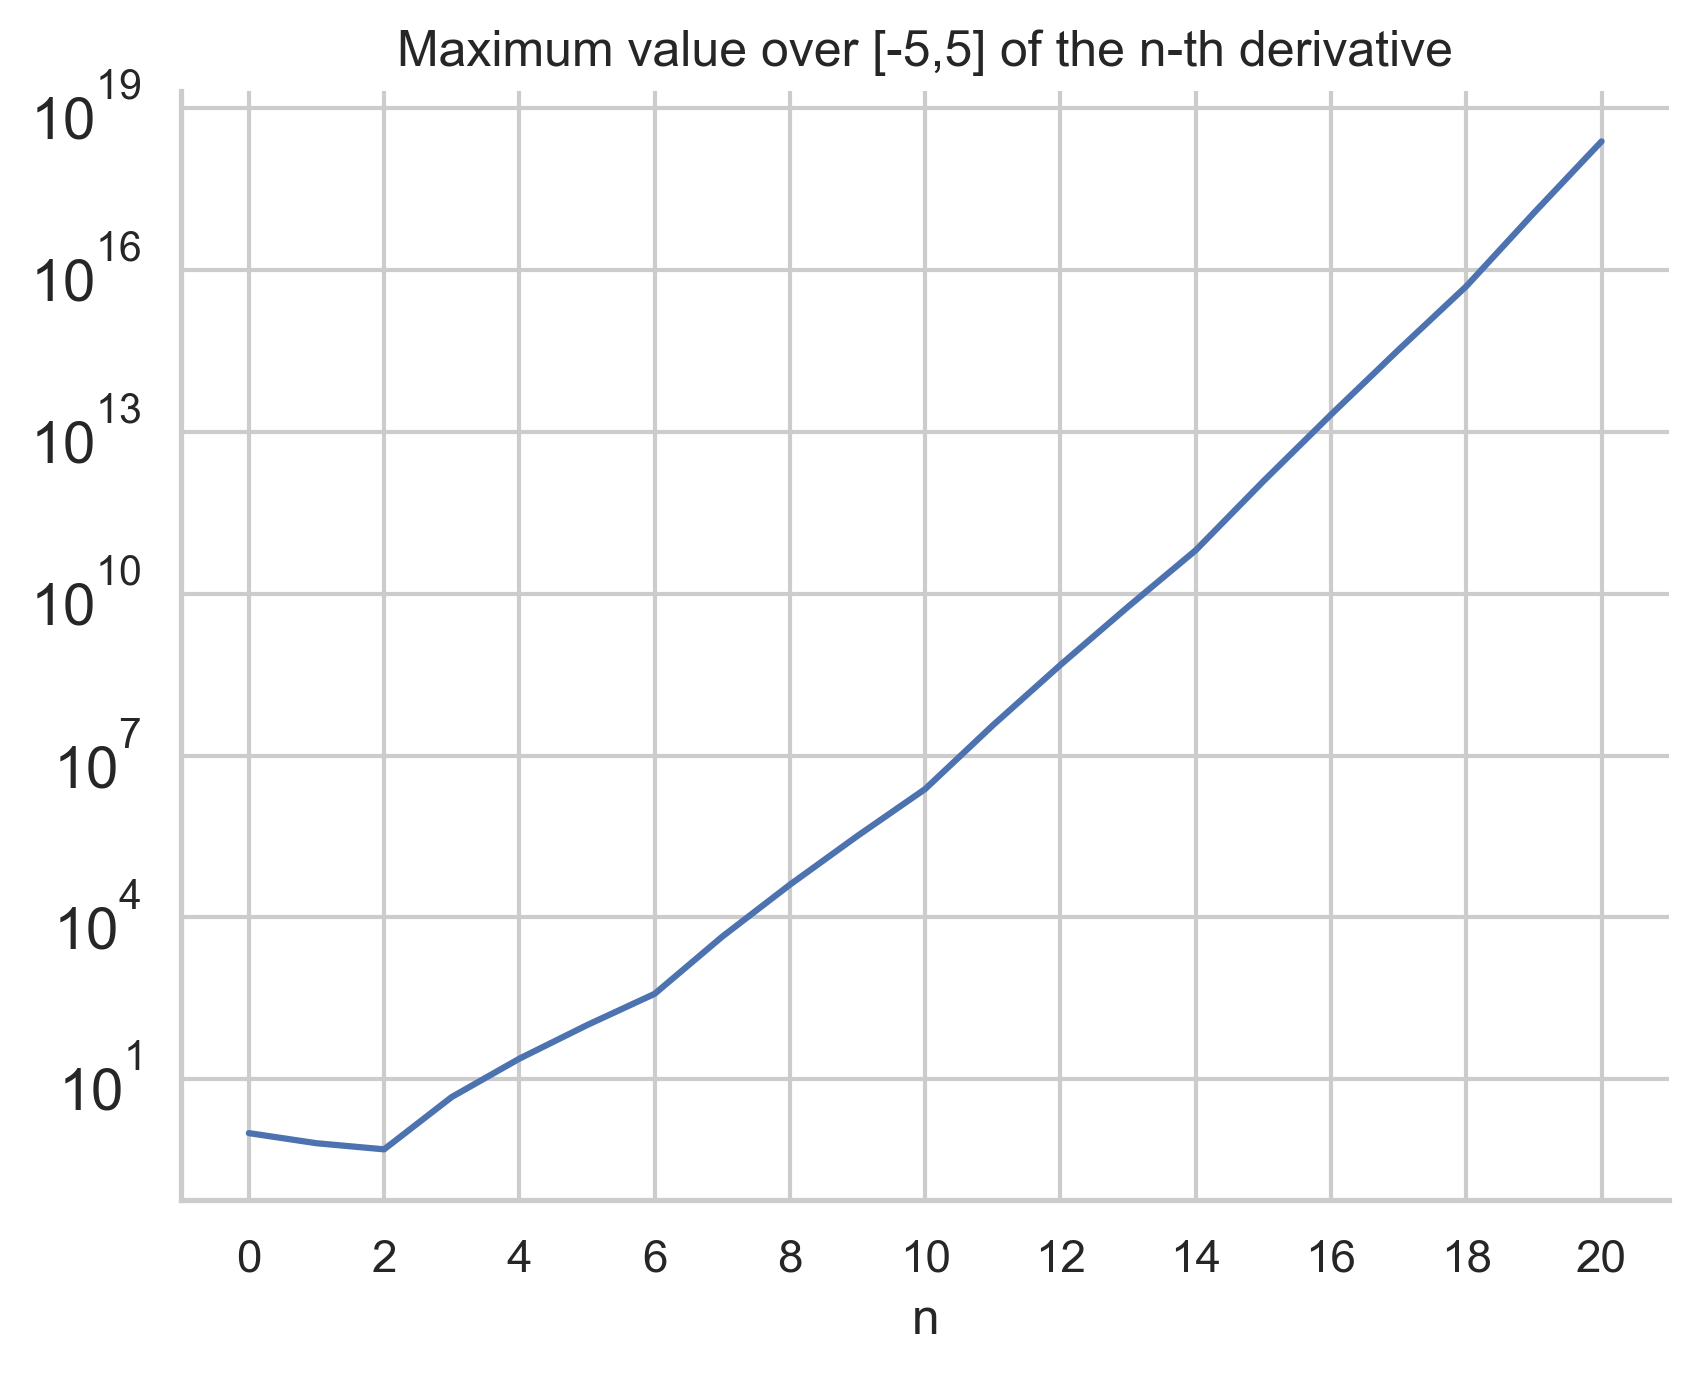

,n,max
0,0,9.999937e-01
1,5,1.004582e+02
2,10,2.393788e+06
3,15,1.216009e+12
4,20,2.429387e+18


In [5]:
#A function which gives us the max of the n-th derivative over [-5,5]
def max_nth_derivative(n):
    x = sp.Symbol('x')
    #The Runge function
    y = 1/(1 + x**2)
    #The n-th derivatve
    y_n = y
    i = 0
    while i < n:
        y_n = y_n.diff(x)
        i +=1

    #Creating the function that evaluates the n-th derivative
    f = sp.lambdify(x, y_n, 'numpy')

    #Returning the max over the interval [-5,5]
    return max(f(np.linspace(-5, 5, 2000)))

#Calculating the value of the max of the n-th derivative
n_min = 7
n_max = 20
n_vals = [int(n) for n in np.linspace(0, n_max, n_max+1)]
reduced_n_vals = n_vals[::5]
vals = [max_nth_derivative(n) for n in n_vals]
reduced_vals = vals[::5]

#A dataframe illustrating the blow up as n increases
df1 = pd.DataFrame(columns=['n', "max"])
# df1["n"] = n_vals[n_min:]
# df1["max"] = vals[n_min:]
df1["n"] = reduced_n_vals
df1["max"] = reduced_vals
plt.rcParams['figure.dpi'] = dpi_val
sns.set_theme(style="whitegrid")
plt.plot(n_vals, vals)
plt.title("Maximum value over [-5,5] of the n-th derivative")
plt.yscale('log')
plt.xlabel("n")
plt.xticks([i for i in range(0,21,2)])
plt.yticks(size=14)
sns.despine()
plt.savefig("Images/max over log scale")
plt.show()
#print(df1.style.to_latex())
df1


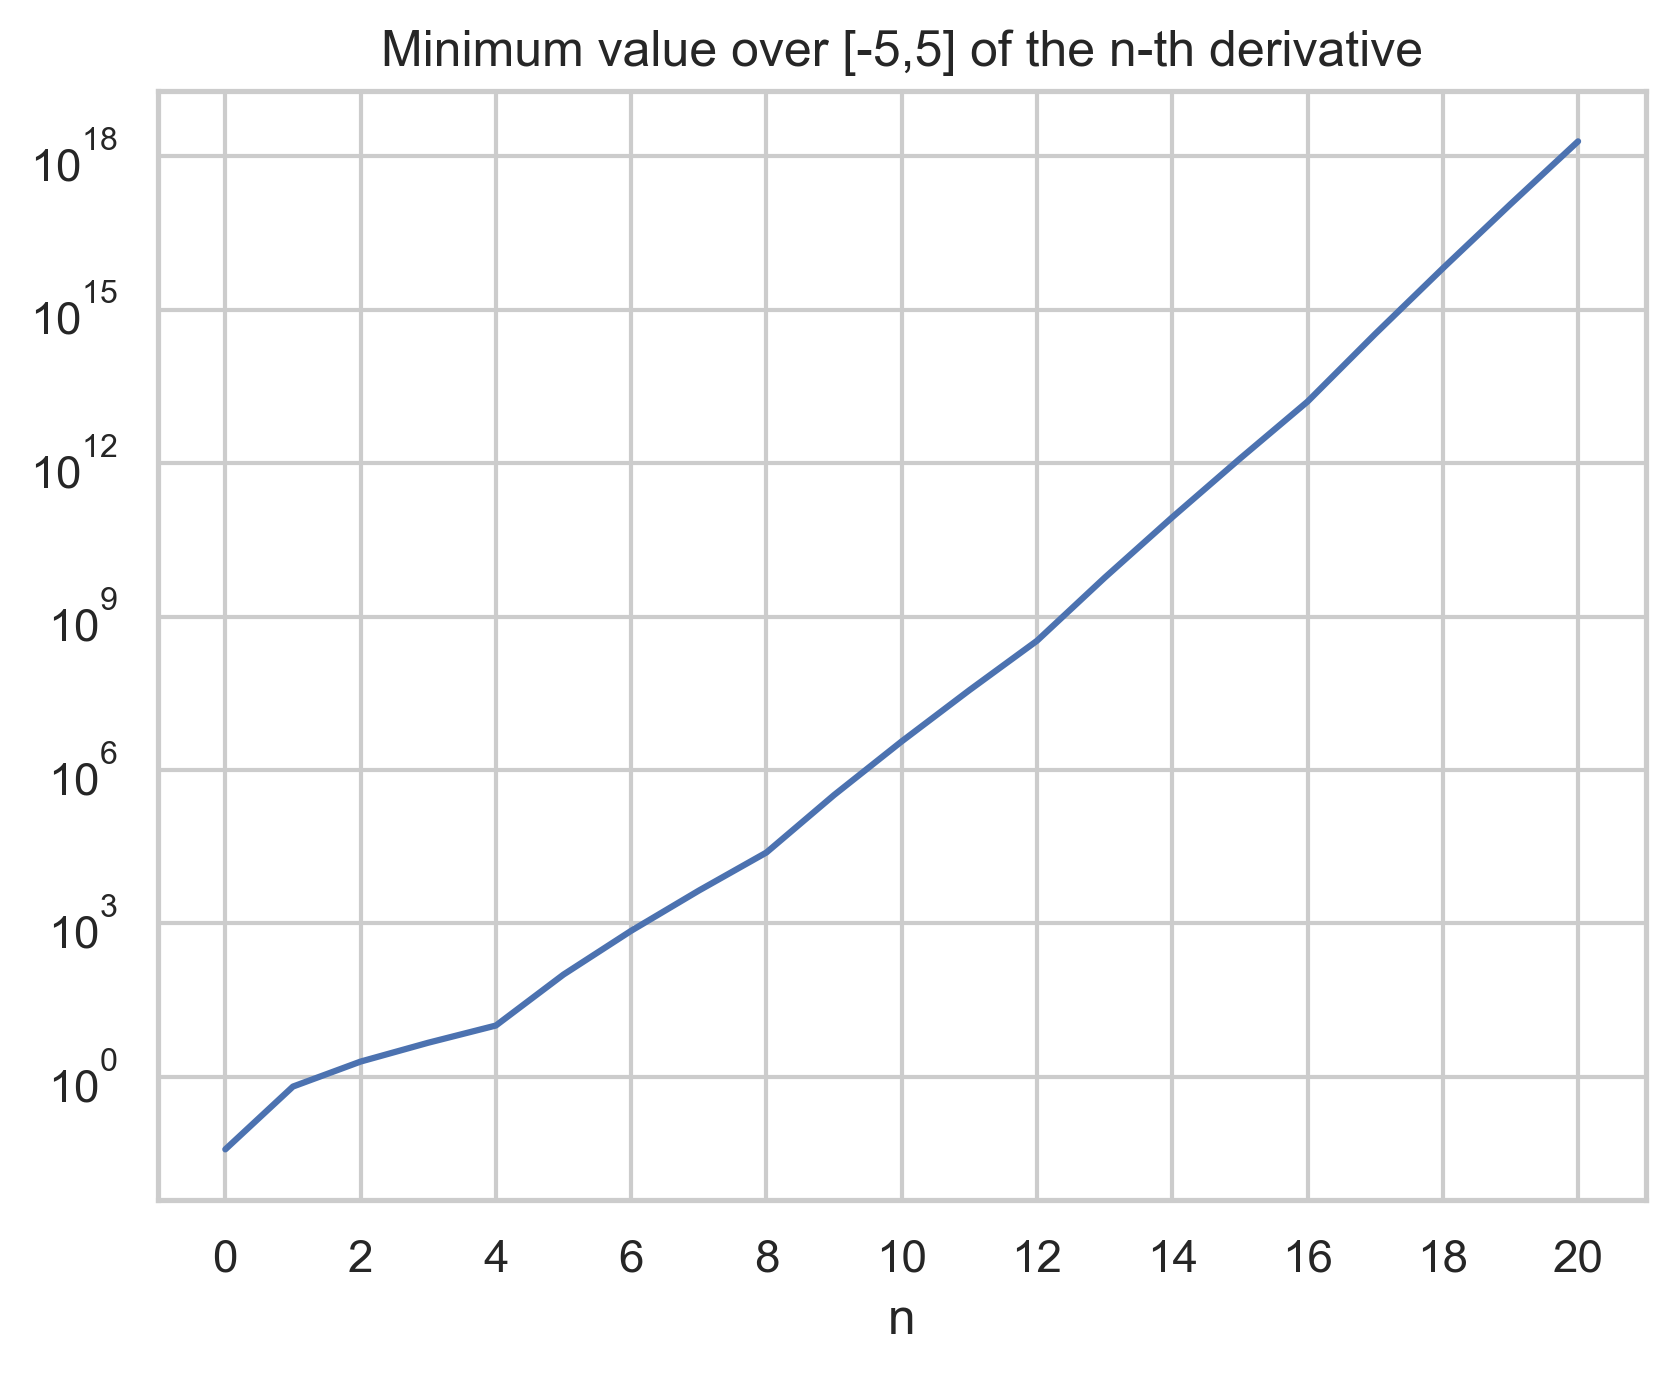

,n,|min|
0,0,3.846154e-02
1,5,1.004582e+02
2,10,3.627302e+06
3,15,1.216009e+12
4,20,1.941923e+18


In [6]:
#A function which gives us the min of the n-th derivative over [-5,5]
def min_nth_derivative(n):
    x = sp.Symbol('x')
    #The Runge function
    y = 1/(1 + x**2)
    #The n-th derivatve
    y_n = y
    i = 0
    while i < n:
        y_n = y_n.diff(x)
        i +=1

    #Creating the function that evaluates the n-th derivative
    f = sp.lambdify(x, y_n, 'numpy')

    #Returning the max over the interval [-5,5]
    return np.abs(min(f(np.linspace(-5, 5, 2000))))

#Calculating the value of the max of the n-th derivative
n_min = 7
n_max = 20
n_vals = [int(n) for n in np.linspace(0, n_max, n_max+1)]
reduced_n_vals = n_vals[::5]
vals = [min_nth_derivative(n) for n in n_vals]
reduced_vals = vals[::5]

#A dataframe illustrating the blow up as n increases
df2 = pd.DataFrame(columns=['n', "|min|"])
# df2["n"] = n_vals[n_min:]
# df2["|min|"] = vals[n_min:]
df2["n"] = reduced_n_vals
df2["|min|"] = reduced_vals
plt.plot(n_vals, vals)
plt.rcParams['figure.dpi'] = dpi_val
sns.set_theme(style="whitegrid")
plt.title("Minimum value over [-5,5] of the n-th derivative")
plt.yscale('log')
plt.xlabel("n")
plt.xticks([i for i in range(0,21,2)])
plt.savefig("Images/min over log scale")
plt.show()
df2

## 1.3 One possible solution: Chebychev points

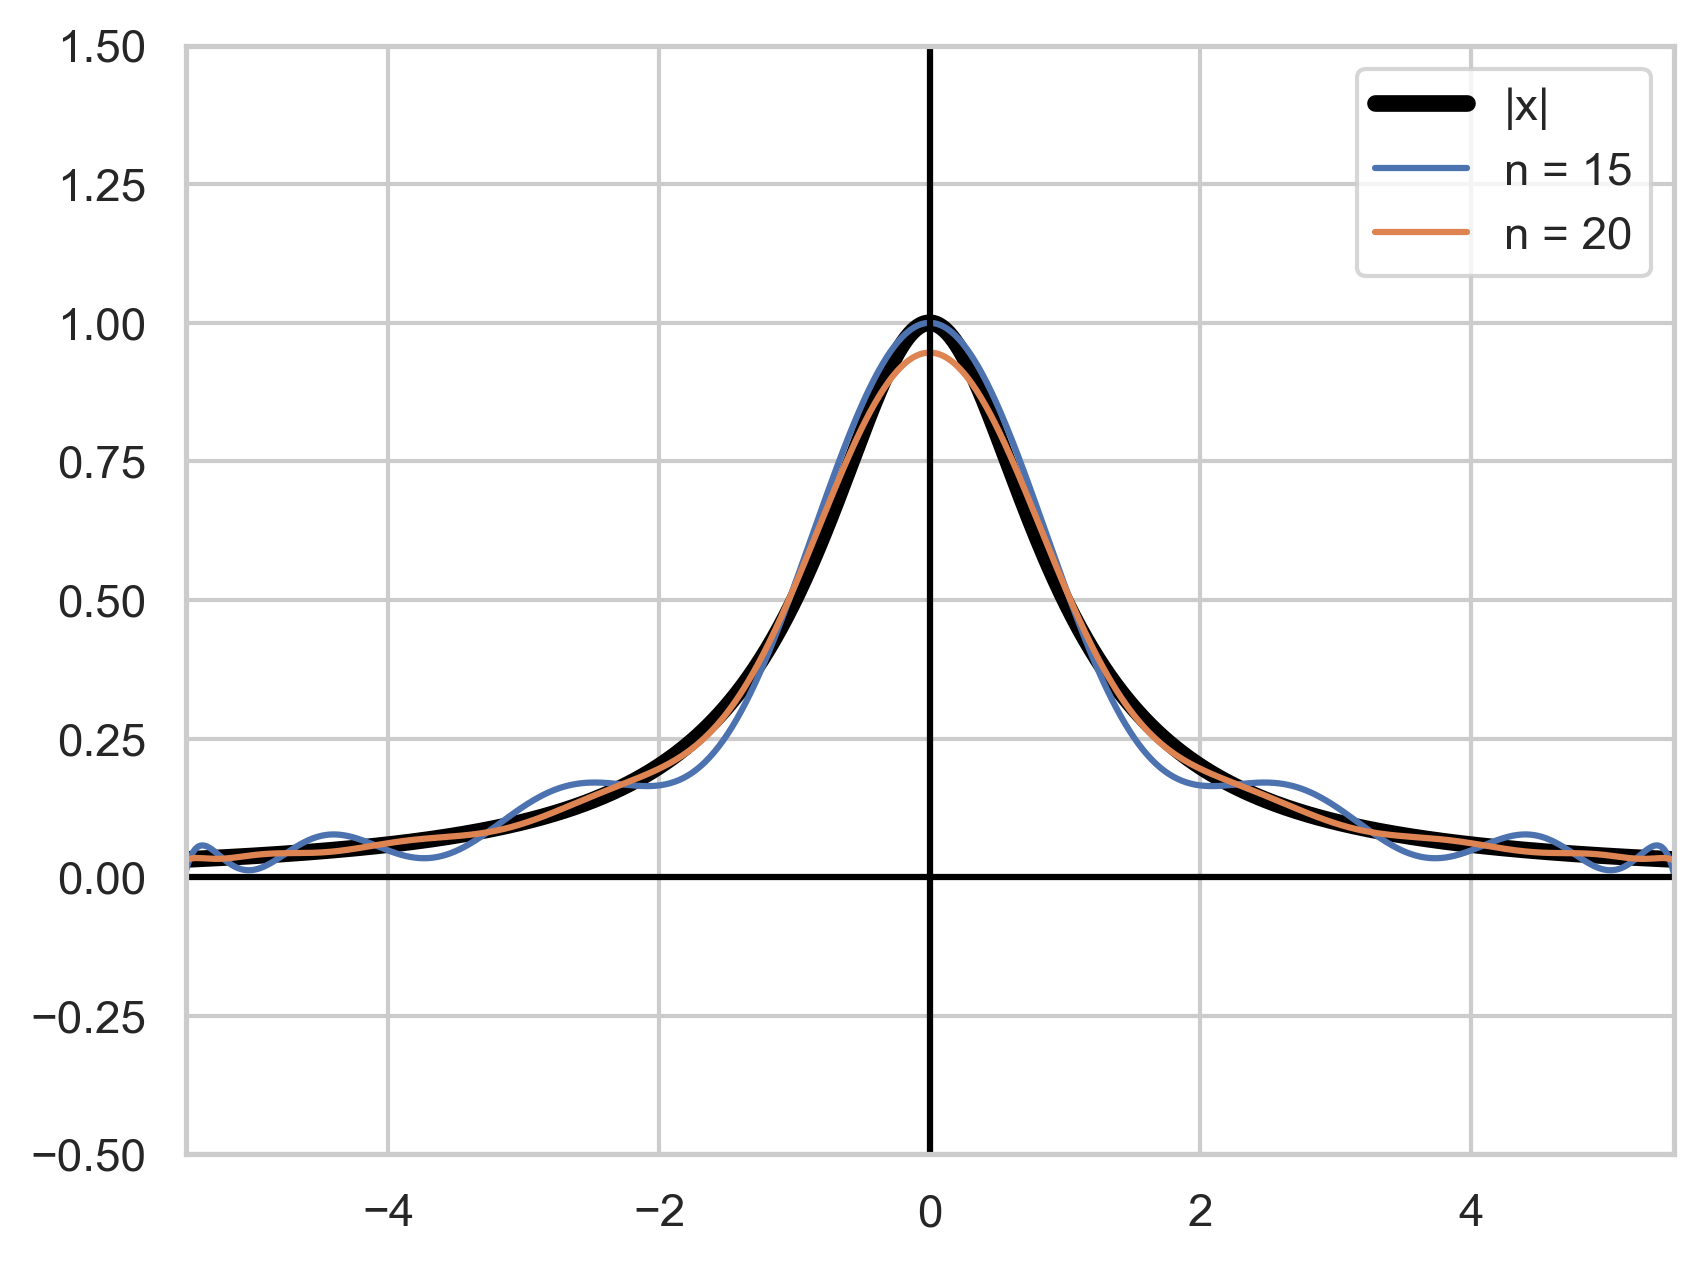

In [7]:
#Using Cheby = True
#The figure and some variables
fig, ax = plt.subplots(dpi=dpi_val)
ax.set_ylim([-0.5, 1.5])
ax.set_xlim([-5.5, 5.5])
a = -5
b = 5
extra = 0.5
lower = a - extra
upper = b + extra
res = 1000

#The real function  
exact_vals = [runge_func(t) for t in np.linspace(lower, upper, res)]
ax.plot(np.linspace(lower, upper, res), exact_vals, linewidth=4, color="black")   

#The Lagrangian polynomial interpolation
for n in [15, 20]:
    n_th = poly_interpolation(n, runge_func, cheby=True, a = lower, b = upper)
    vals = [n_th(t) for t in np.linspace(lower, upper, res)]
    ax.plot(np.linspace(lower, upper, res), vals)

#x and y axis lines
plt.axhline(y=0, color='black', linestyle='-')
plt.axvline(x=0, color='black', linestyle='-')
plt.legend(["|x|", "n = 15", "n = 20"])

plt.show()

## 1.4 Solution to the problem that I used: Spline Interpolation

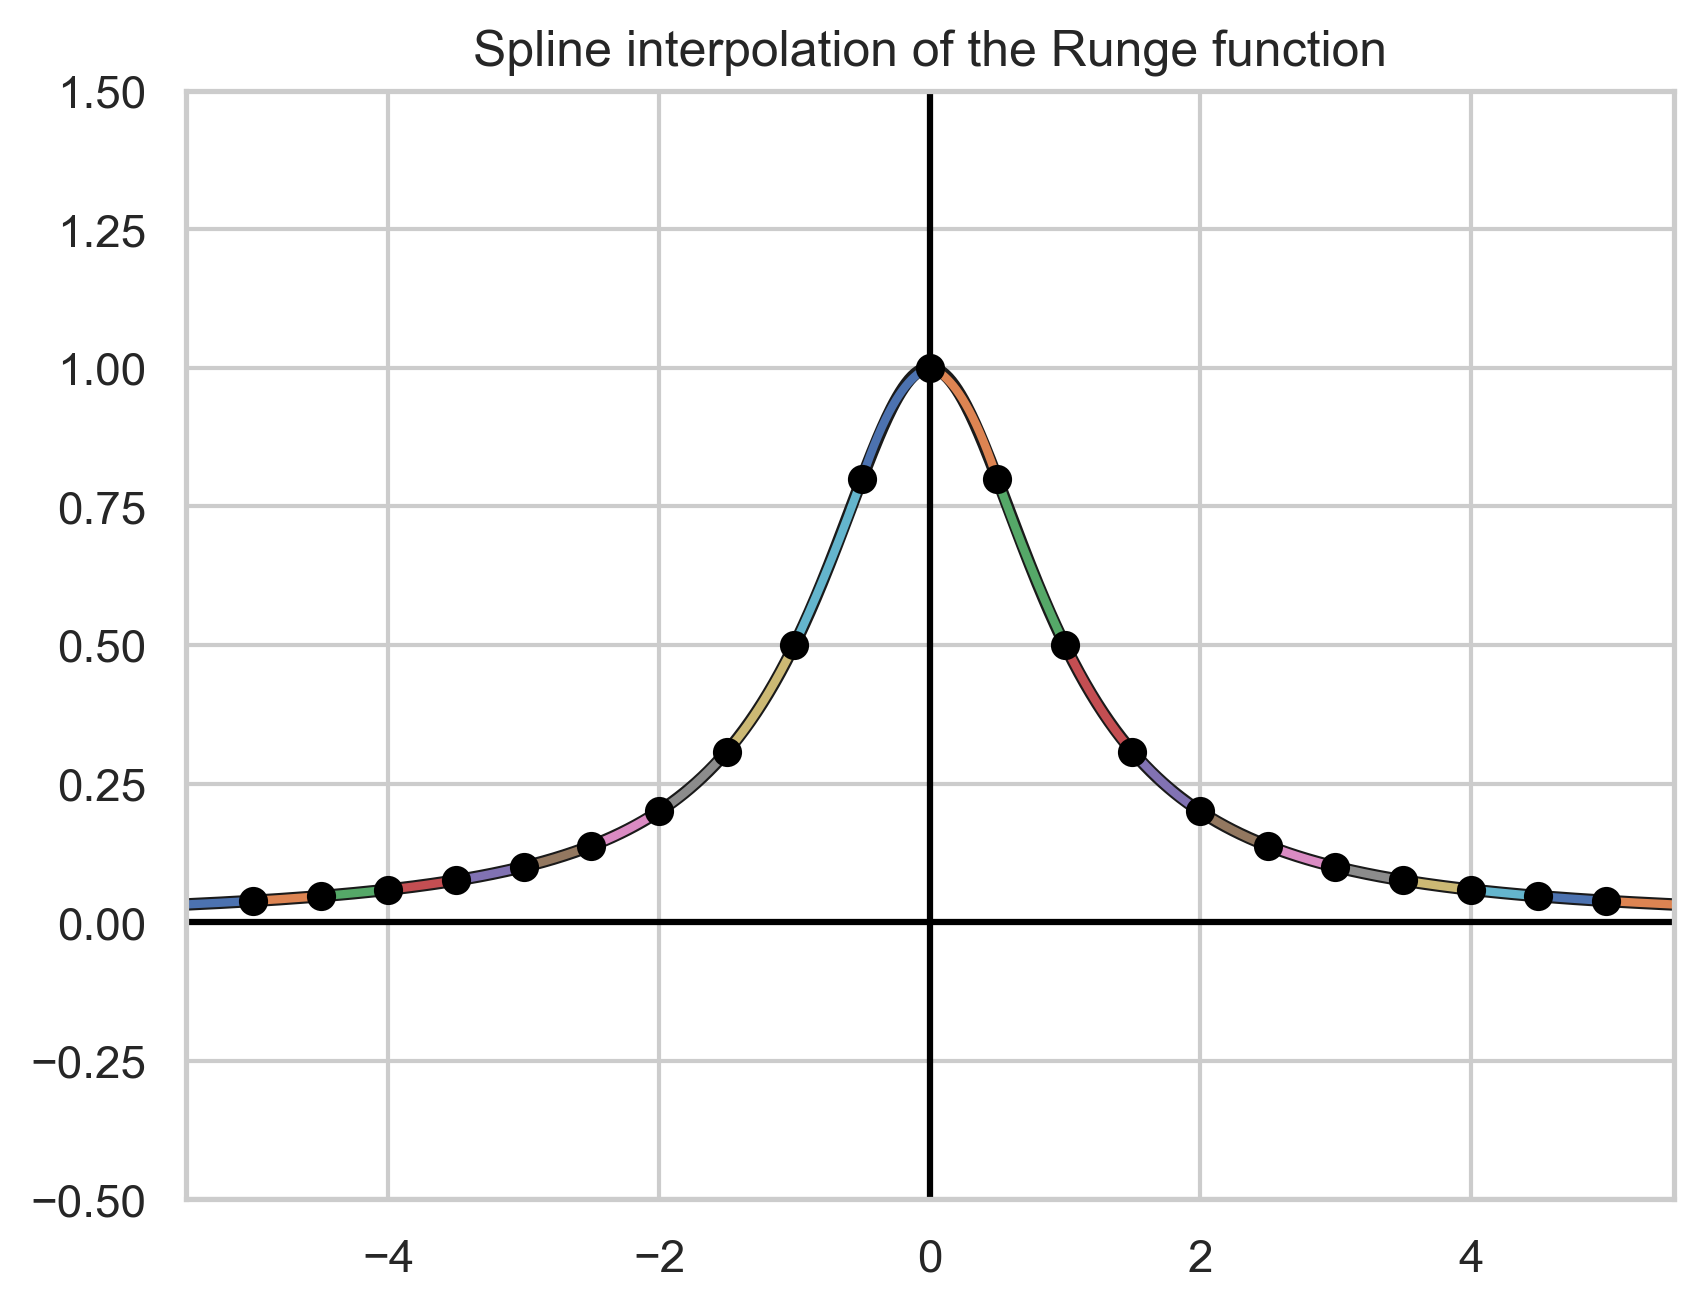

In [8]:
#A function which interpolates on each such interval
def composite_interpolation(n: int, f, a: float, b: float, h: float, res: float):
    """
    A function which calculates the interpolating polynomial on many subintervals of [a,b]

    Inputs:
    n: The number of data points used in interpolating a polynomial over a single subinterval
    f: Function that we are trying to approximate using lagrangian interpolation 
    a: The lower extreme of the interval we are interpolating over. Also the first interpolating point of the first subinterval
    b: The upper extreme of the interval we are interpolating over. Also the last interpolating point of the last subinterval
    h: Size of each subinterval
    res: The resolution of the plots produces

    Output:
    Axes subplot containing all the interpolating polynomials over all the subintervals. I also add the plot of the real function

    """
    #Computing the number of steps and a list of each times step
    numb_steps = int((b - a)//h)+1
    time_steps = [a + j*h for j in range(numb_steps)]

    #Creating the figure
    fig, ax = plt.subplots(dpi=dpi_val)

    #The real function plot
    exact_vals = [f(t) for t in np.linspace(a, b, res)]
    ax.plot(np.linspace(a, b, res), exact_vals, linewidth=3, color = "k")
    
    #Running over all the subintervals
    for i in range(numb_steps-1):
        #Subdividing each subinterval
        x = np.linspace(time_steps[i], time_steps[i+1], res)

        #Interpolating a polynomial over a single subinterval [time_step[i], time_step[i+1]]
        single_interpolant = poly_interpolation(n, f, False, time_steps[i], time_steps[i+1])

        #The values to plot the interpolating polynomial
        values = [single_interpolant(t) for t in x]

        #Adding the plot
        ax.plot(x, values, linewidth=2)
    return ax

#Some variables used for the plot
n = 3
h = 0.5
a = -5
b = 5
extra = 0.5
lower = a - extra
upper = b + extra
res = 1000

#Calling the function on the variables
ax = composite_interpolation(n, runge_func, lower, upper, h, res)
ax.set_ylim([-0.5, 1.5])
ax.set_xlim([-5.5, 5.5])

#Plotting the data points
numb_steps = int((b - a)//h)+1
time_steps = [a + j*h for j in range(numb_steps)]
y = np.vectorize(runge_func)(time_steps)
ax.plot(time_steps,y,'o', color="black")

#x and y axis lines
plt.axhline(y=0, color='black', linestyle='-')
plt.axvline(x=0, color='black', linestyle='-')
plt.title("Spline interpolation of the Runge function")
plt.savefig("Images/Spline interpolation")
plt.show()

### 1.4.1 Lack of differentiability at the points of interpolation

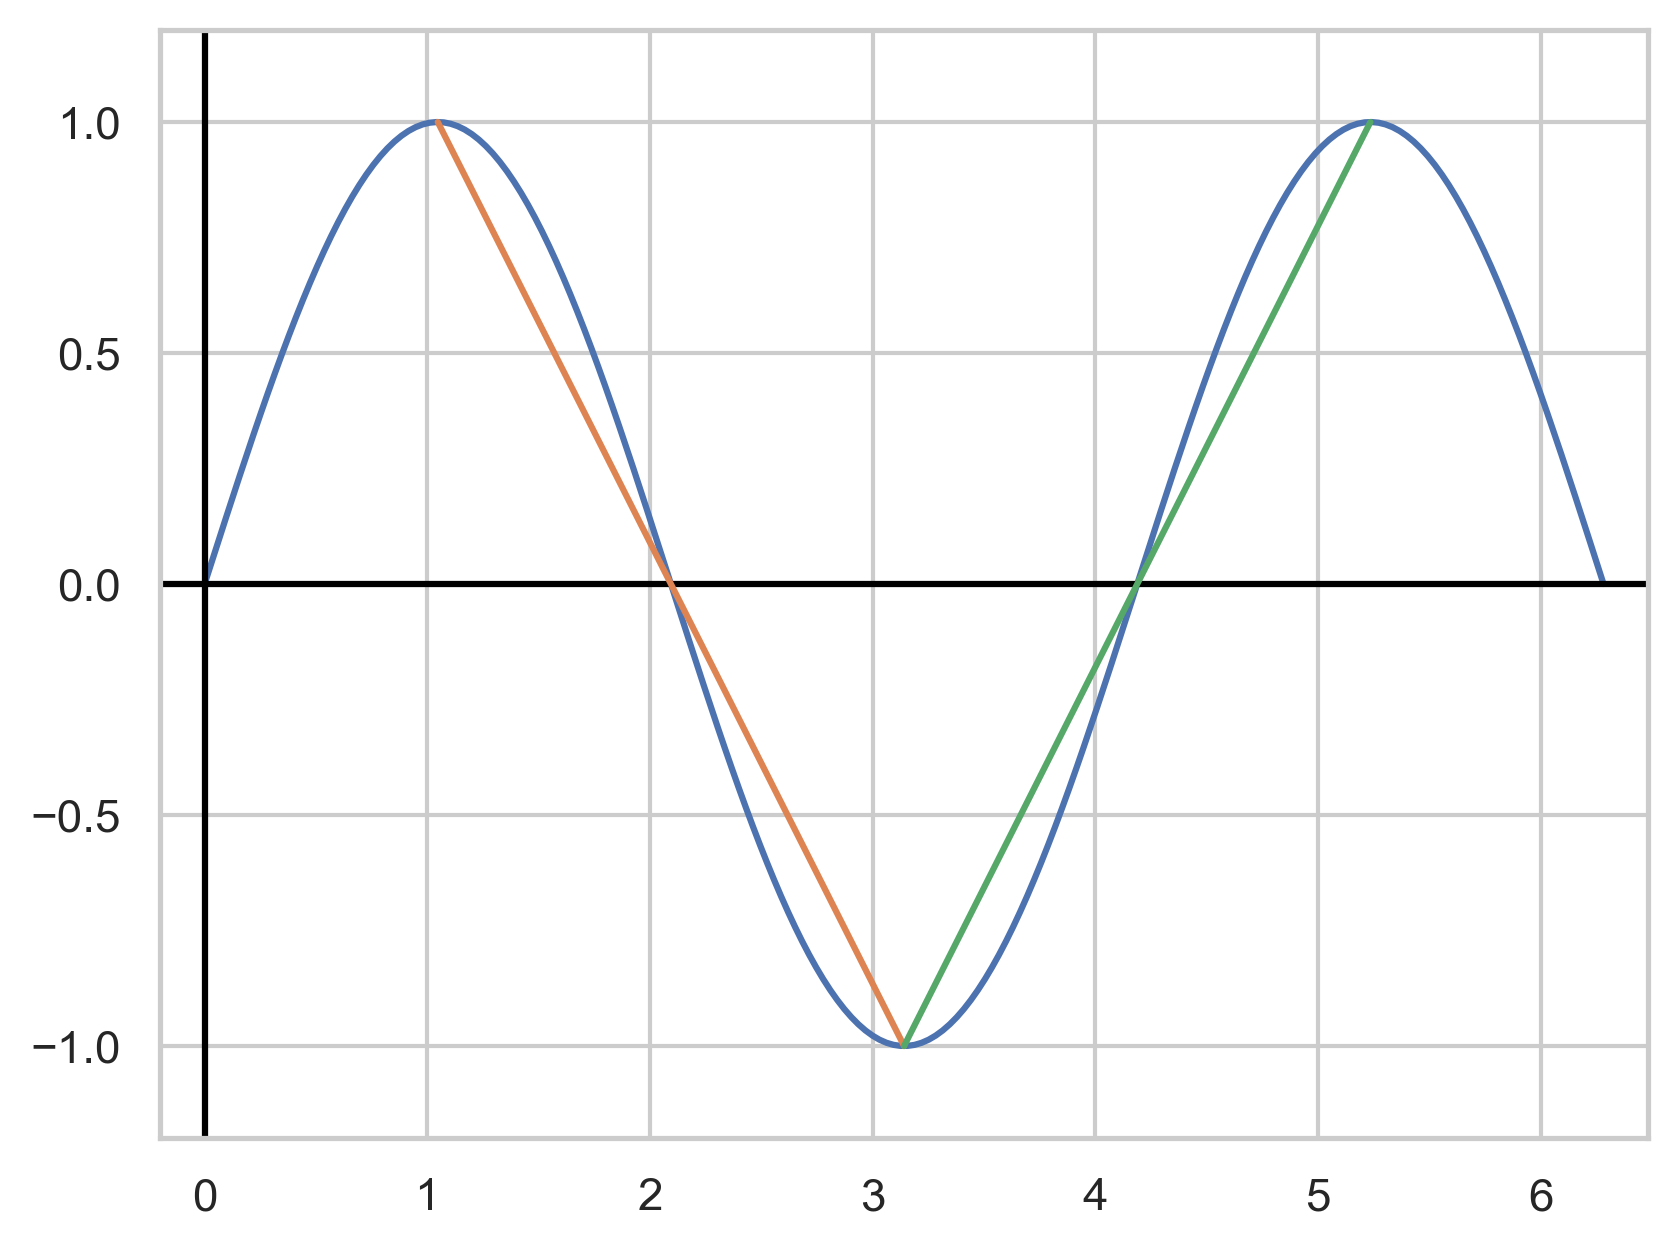

In [9]:
#Plotting an example where we do not have differentiabiliy at the points of interpolation
fig, ax = plt.subplots(dpi=dpi_val)
ax.set_ylim([-1.2, 1.2])
ax.set_xlim([-0.2, 2 * np.pi + 0.2])
a = 0
b = 2 * np.pi
def func(x):
    return np.sin(1.5 * x)

x = np.linspace(a,b, 200)
y = func(x)
ax.plot(x,y)
plt.axhline(y=0, color='black', linestyle='-')
plt.axvline(x=0, color='black', linestyle='-')

#Interpolation at points (pi/3, 1) and (pi, -1)
line1 = poly_interpolation(2,func,a=np.pi/3, b=np.pi)
x = np.linspace(np.pi/3,np.pi)
y = line1(x)
ax.plot(x,y)

#Interpolation at points (pi, -1) and (5*pi/3, 1)
line2 = poly_interpolation(2,func,a=np.pi, b=5*np.pi/3)
x = np.linspace(np.pi,5*np.pi/3)
y = line2(x)
ax.plot(x,y)
plt.show()

---
# 2. Numerical Integration


## 2.1 Trapezoid method

In [10]:
def trap_integration(f, a: float, b: float, n: int, grid: list = None):
    """
    Implementation of the Trapezoid method for numerical integration.

    Inputs:
    f: A function that takes real inputs and returns real outputs which we would like to integrate
    a: A float acting as the lower extreme of the interval on which we are integrating
    b: A float number acting as the upper extreme of the interval on which we are integrating. Should be strictly large than a
    n: If grid is None this will tell us the number of intervals we will subdivide the interval [a,b]
    grid: If not None this is list of data points which will be used to implement the trapezoid method with non-uniform grid

    Output:
    A float that is the approximate solution to the integral of f over in interval [a,b]
    """

    #Grid size
    if grid is None:
        #Grid must be uniform
        h = (b-a)/n
        data_points = [a + i * h for i in range(n+1)]
    else:
        #The grid given as an input (possibly non-uniform)
        data_points = grid

    #Variable that keeps track of the sum over the subintervals
    t = 0
    
    #For loop running over all the grid points (x_t - x_(t-1))
    x_2 = data_points[0]
    for i in range(1, n+1):
        x_1 = data_points[i]
        t += 0.5 * (x_1 - x_2) * (f(x_1) + f(x_2))
        x_2 = x_1
        
    return t

### 2.1.1 Convergence of differentiable vs non-differentiable

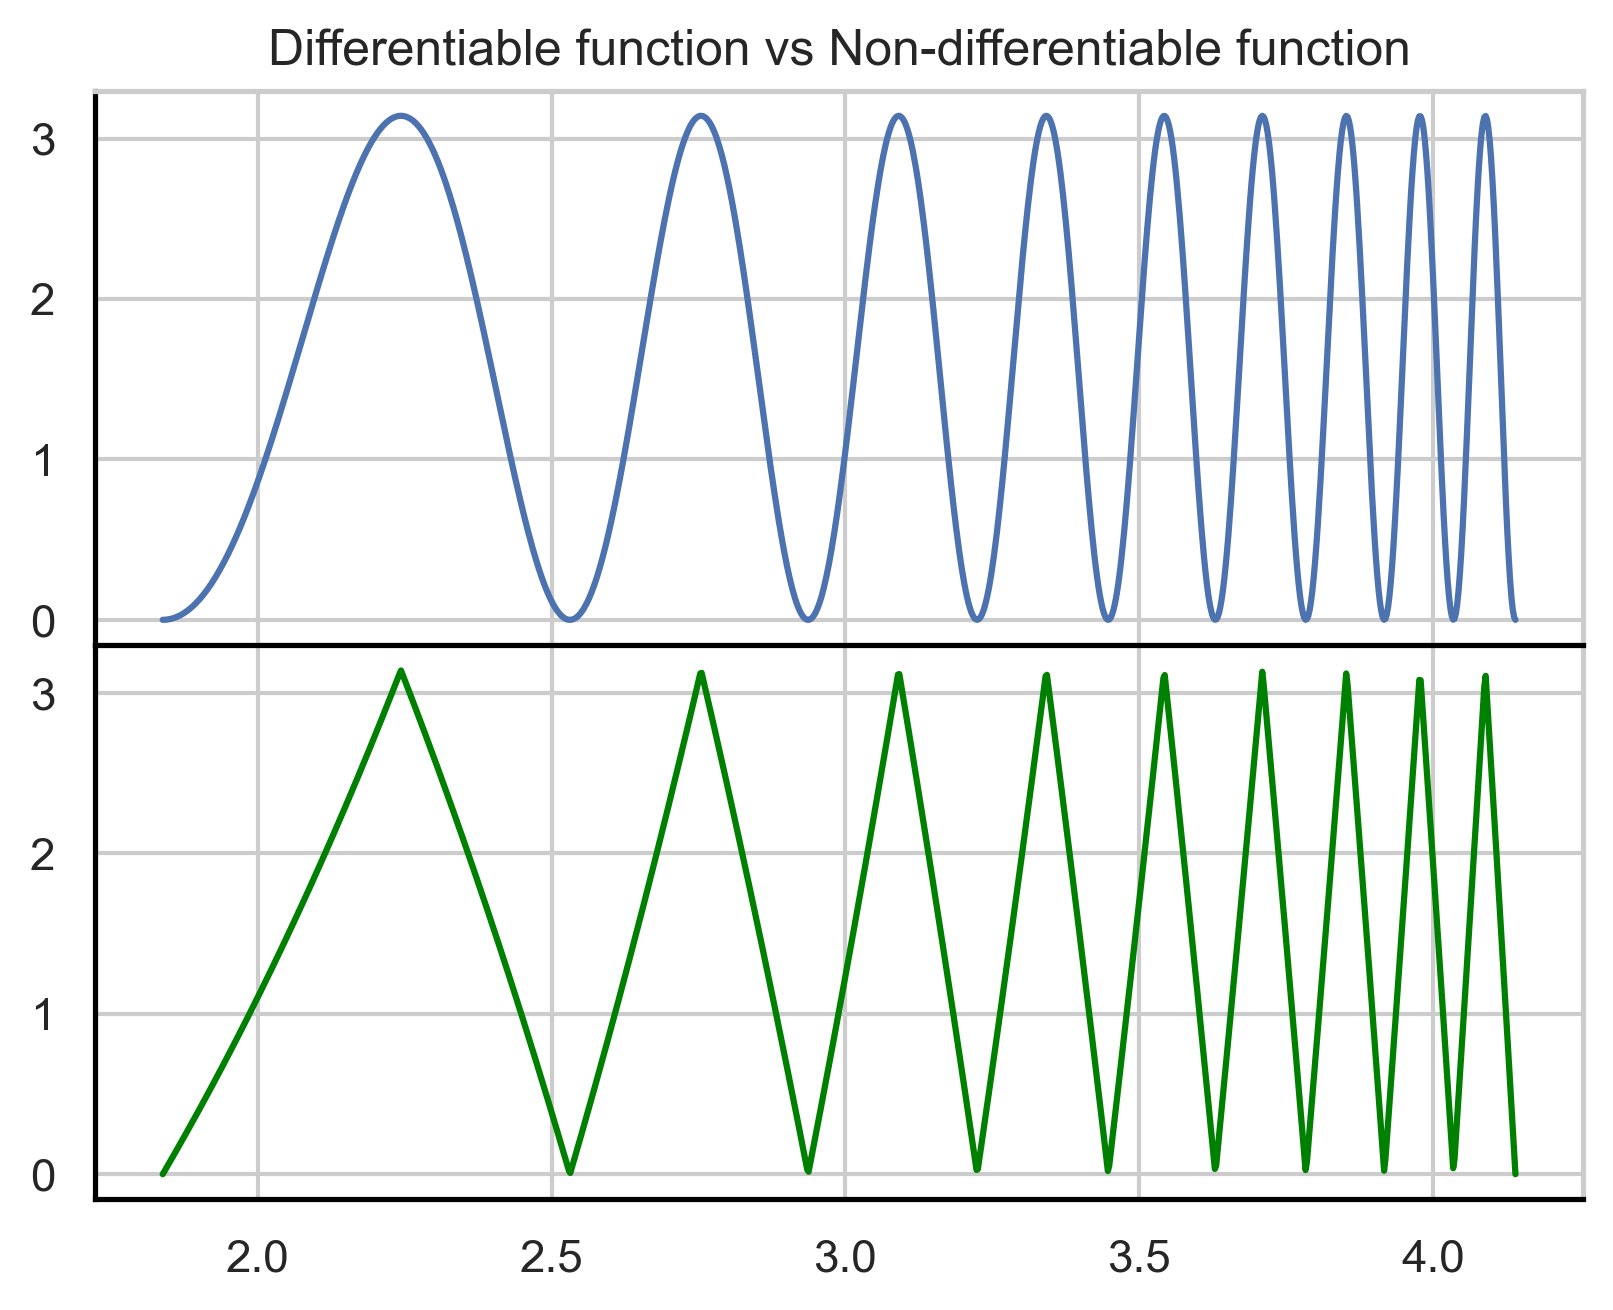

In [59]:
#The non-differentiable function used in my example
def non_diff(x):
    return np.arccos(np.cos(np.exp(x)))

#A differentiable function that is very similar to the non-differentiable function
def diff(x):
    return np.pi/2 * np.cos(np.exp(x) + np.pi) + np.pi/2

#Vectorizing the functions
non_diff = np.vectorize(non_diff)
diff = np.vectorize(diff)

#Plotting the two functions
fig = plt.figure(dpi=dpi_val)
gs = fig.add_gridspec(2, hspace=0)
ax = gs.subplots(sharex=True, sharey=True)

#The extrema of interest
a = np.log(2 * np.pi)
b = np.log(20 * np.pi)

#Plotting the functions
x = np.linspace(a, b, 1000)
diff_vals = diff(x)
non_diff_vals = non_diff(x)
ax[0].plot(x, diff_vals)
ax[1].plot(x, non_diff_vals, color='Green')

#Setting the axis colours
ax[0].spines['left'].set_color('black')
ax[1].spines['left'].set_color('black')
ax[1].spines['top'].set_color('black')
ax[1].spines['bottom'].set_color('black')

#The first plot should share the horizontal axis values
ax[0].label_outer()

ax[0].set_title("Differentiable function vs Non-differentiable function")
fig.savefig("Images/" + "diff vs non-diff")
plt.show()


In [75]:
#A function that returns values used for plots and tables
def diff_vs_non_diff(method, diff_func, non_diff_func, a, b, n_max):
    """
    Implementation of a integration method to a differentiable and non-differentiable function.

    Inputs:
    method: An integration method (in my code either trapezoid or Simpson's)
    diff_func: A np.vectorized function that is differentiable
    non_diff_func: A np.vectorized function that is non-differentiable
    a: The lower extreme of integration
    b: The upper extreme of integration
    n_max: Maximum value of n used to calcualte the values

    Output:
    Three lists: values of n, values of method applied to diff_func, values of method applied to non_diff_func
    """
    n_list = range(1,n_max + 1)
    diff_vals = []
    non_diff_vals = []
    for n in n_list:
        non_diff_vals.append(method(non_diff_func, a, b, n))
        diff_vals.append(method(diff_func, a, b, n))
    
    return n_list, diff_vals, non_diff_vals

def table_diff_vs_non_diff(method, diff_func, non_diff_func, a, b, n_max, step=2, n_large=1000):
    #Getting the values of the functions
    n_list, diff_vals, non_diff_vals = diff_vs_non_diff(method, diff_func, non_diff_func, a, b, n_max)

    #Approximation with n_large
    real_diff = method(diff_func, a, b, n_large)
    real_non_diff = method(non_diff_func, a, b, n_large)

    #Table with all the values
    cols = ["n", "Estimator_diff", "Estimator_non_diff", "Errors_diff", "Error_non_diff"]
    Error_diff = []
    Error_non_diff = []

    #Values of interest
    number_of_indexs = int(np.emath.logn(step, n_max)) + 1
    print(number_of_indexs)
    indexs = [step**i - 1 for i in range(1, number_of_indexs)]

    for i in indexs:
        Error_diff.append(abs(diff_vals[i] - real_diff))
        Error_non_diff.append(abs(non_diff_vals[i] - real_non_diff))
        
    #The dataframe
    df = pd.DataFrame(columns=cols)
    df["n"] = np.array(n_list)[indexs]
    df["Estimator_diff"] = np.array(diff_vals)[indexs]
    df["Estimator_non_diff"] = np.array(non_diff_vals)[indexs]
    df["Errors_diff"] = Error_diff
    df["Error_non_diff"] = Error_non_diff 
    df.reset_index(drop=True, inplace=True)
    #print(df.to_latex())
    display(df)

In [76]:
table_diff_vs_non_diff(trap_integration, diff, non_diff, a, b, 512, step=2, n_large=1000)

10


,n,Estimator_diff,Estimator_non_diff,Errors_diff,Error_non_diff
0,2,0.861382,1.173882,2.720469e+00,2.414046
1,4,2.725040,2.750954,8.568116e-01,0.836974
2,8,4.068740,3.944921,4.868892e-01,0.356993
3,16,4.061413,4.000377,4.795619e-01,0.412449
4,32,3.575971,3.583811,5.880520e-03,0.004117
5,64,3.581785,3.575178,6.635477e-05,0.012750
6,128,3.581848,3.592909,2.971576e-06,0.004981
7,256,3.581851,3.588216,1.710565e-07,0.000288
8,512,3.581851,3.588230,9.810684e-09,0.000302


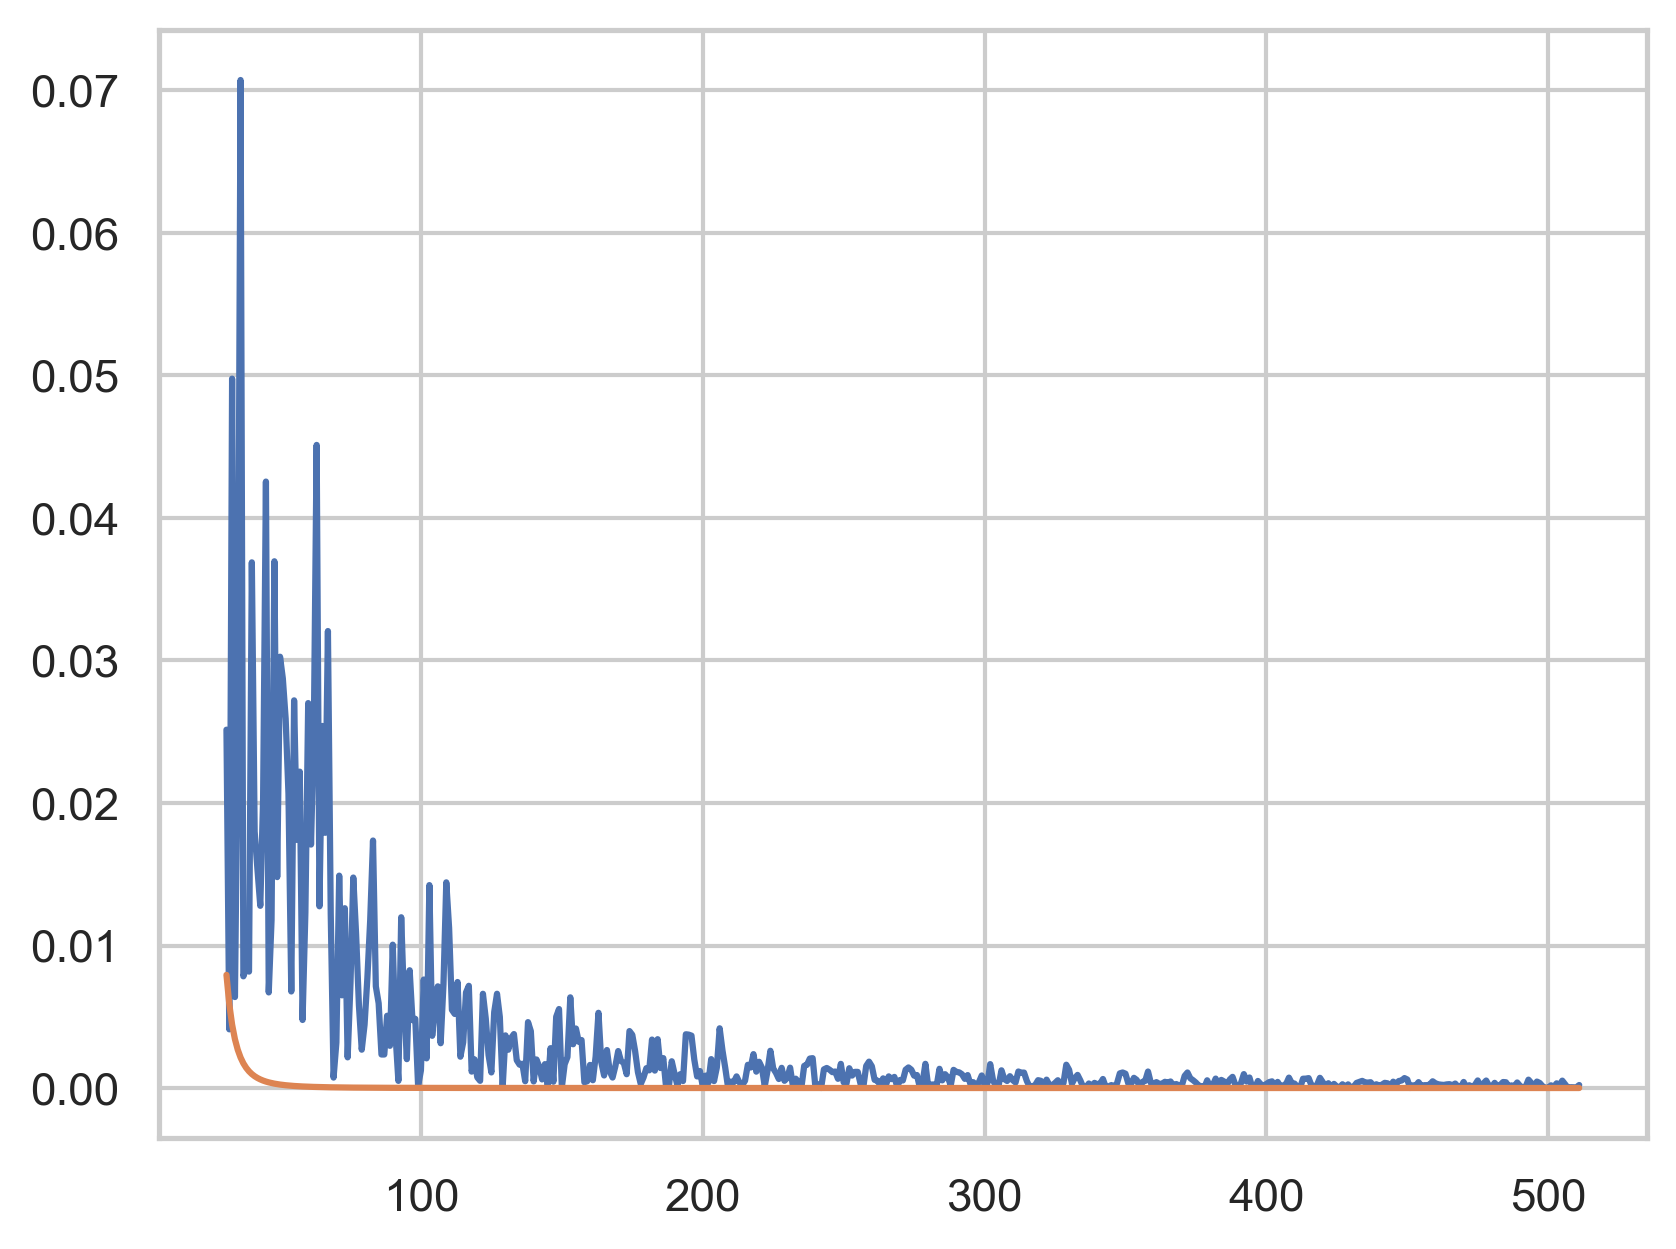

In [55]:

n_list = range(1,512)
diff_vals = []
non_diff_vals = []
fig, ax = plt.subplots()
real_diff = trap_integration(diff, a, b, 1000)
real_non_diff = trap_integration(non_diff, a, b, 1000)
for n in n_list:
    non_diff_vals.append(abs(trap_integration(non_diff, a, b, n)-real_non_diff))
    diff_vals.append(abs(trap_integration(diff, a, b, n)- real_diff))

ax.plot(n_list[30:], non_diff_vals[30:])
ax.plot(n_list[30:], diff_vals[30:])
plt.show()



## 2.2 Simpson's method

In [56]:
def simpson(f, a: float, b: float, n: int):
    """
    Implementation of the Simpson's method for numerical integration.

    Inputs:
    f: A function that takes real inputs and returns real outputs which we would like to integrate
    a: A float acting as the lower extreme of the interval on which we are integrating
    b: A float number acting as the upper extreme of the interval on which we are integrating. Should be strictly large than a
    n: An even natural number strict greater than 1 and counts the number of interval we subdivide the interval [a,b]

    Output:
    A float that is the approximate solution to the integral of f over in interval [a,b]
    """

    #Factors which are multipled by 1
    s1 = f(a) + f(b)
    #Factors which are multipled by 2
    s2 = 0
    #Factors which are multipled by 4
    s4 = 0
    #Grid size
    h = (b-a)/n

    #For loop running over all the grid points
    for i in range(1, n):
        x = a + i * h
        if i % 2 == 1:
            #Odd indices get added to s4
            s4 += f(x)
        else:
            #Even indices get added to s2
            s2 += f(x)
    
    return h/3*(s1 + 4*s4 + 2*s2)


def table_of_approx_simp(f, a, b, real_integral, n_max, step=2):
    """
    Give a dataframe with values in the columns as we vary the values of h

    Inputs:
    f,a,b: Inputs for the simpson function
    real_integral: Real value of the integral we are trying to approximate
    n_max: The largest value that will be added to the table at least greater than 1
    step: Increment to n at each iteration or the number that h gets divided by
    
    Output:
    Dataframe with columns according to the imputs
    """
    
    #Init some lists that we will need to add to the dataframe
    cols = ["n", "h", "S_n", "Errors", "Error_ratio"]
    h_vals = []
    n_vals = []
    S_vals = []
    Error_vals = []
    Error_ratio_vals = []
    count = 0
    #Calcualting the values
    i = step
    while i <= n_max:
        h_vals.append((b-a)/i)
        n_vals.append(i)
        S_vals.append(simpson(f,a,b,i))
        Error_vals.append(abs(real_integral - S_vals[count]))
        #Cannot calculate the very first value
        if count > 0:
            Error_ratio_vals.append(Error_vals[count-1]/Error_vals[count])
        else:
            Error_ratio_vals.append("N.A")
        count += 1
        i *= step
    #The dataframe
    df = pd.DataFrame(columns=cols)
    df["h"] = h_vals
    df["n"] = n_vals
    df["S_n"] = S_vals
    df["Errors"] = Error_vals
    df["Error_ratio"] = Error_ratio_vals
    df.reset_index(drop=True, inplace=True)
    #print(df.to_latex())
    display(df)


In [ ]:
#For cubic polynomials the result of Simpson's rule should be exact
def cubic(x):
    return 3*x**3 + 2*x**2 + x + 1

#It is exact!
print("Cubic:", simpson(cubic, 0, 1, 2))


In [57]:
#Simple example with exponential
table_of_approx_simp(np.exp, 0, 1, np.exp(1)-1, 1000,2)

,n,h,S_n,Errors,Error_ratio
0,2,0.500000,1.718861,5.793234e-04,N.A
1,4,0.250000,1.718319,3.701346e-05,15.651695
2,8,0.125000,1.718284,2.326241e-06,15.911277
3,16,0.062500,1.718282,1.455928e-07,15.977714
4,32,0.031250,1.718282,9.102727e-09,15.994422
5,64,0.015625,1.718282,5.689698e-10,15.998612
6,128,0.007812,1.718282,3.556155e-11,15.999575
7,256,0.003906,1.718282,2.222222e-12,16.002698
8,512,0.001953,1.718282,1.383338e-13,16.064205


In [ ]:
#Integral of 1/(1+x) over [0,4]
def hyperbola(x):
    return 1/(1+x)

#The table using Simpson's method knowing that the exact value is ln(5)
table_of_approx_simp(hyperbola, 0, 4, np.log(5), 1000,2)

---
# 3. Numerical Solutions to ODEs

## Example 1

In [ ]:
#This is one ODE we will try to solve. Note that this is a particular case of the ODE used to define Absolute stability
#RHS of differential equation
def simple_ODE(lmda):
    def ODE(t: float, y: float):
        return lmda*y
    return ODE


#For IVP that I will tackle here is always a exact solution
def exact_solution(t, lmda, t_0 = 0.0, y_0 = 3.0):
    return y_0 * np.exp(-lmda * t_0) * np.exp(lmda * t)

#A method that plots the various methods according to h
def example_1(method, l, file_name, h_vals = [1, 0.5, 0.05],  res = 100, t_0 = 0.0, y_0 = 3.0, t_max = 2.0):
    #The figure
    #fig, ax = plt.subplots(figsize=(8,6), dpi=200)
    fig, ax = plt.subplots(dpi=dpi_val)

    #Empty list for legend
    legend_labels = []

    #Plotting for various values of h
    for h in h_vals:
        x, y = method(simple_ODE(l), h, t_0, t_max, y_0)
        ax.plot(x, y, 'o--')

        #Appending to the legend
        legend_labels.append("h=" + str(h))

    #Plot the function that is an exact solution to our IVP
    exact_vals = [exact_solution(t, l) for t in np.linspace(t_0, t_max, res)]
    ax.plot(np.linspace(t_0, t_max, res), exact_vals)

    #Adding the legend
    legend_labels.append("Exact")
    ax.legend(legend_labels)
    plt.xlabel("time")
    plt.title("Exact and approximate solutions, for y' = " + str(l) + "y")
    fig.savefig("Images/" + str(file_name))
    plt.show()

## Example 2

In [ ]:
#RHS of differential equation
def ex2(lmda):
    def ODE(t: float, y: float):
        return lmda * np.sin(t) * y
    return ODE


#For IVP that I will tackle here is always a exact solution
def exact_solution_2(t, lmda, t_0 = 0.0, y_0 = 3.0):
    return y_0 * np.exp(lmda * np.cos(t_0)) * np.exp(-lmda * np.cos(t))

#A method that plots the various methods according to h
def example_2(method, l, file_name, h_vals = [1, 0.5, 0.05],  res = 100, t_0 = 0.0, y_0 = 3.0, t_max = 10.0):
    #The figure
    #fig, ax = plt.subplots(figsize=(8,6), dpi=200)
    fig, ax = plt.subplots(dpi=dpi_val)
    
    #Empty list for legend
    legend_labels = []

    #Plotting for various values of h
    for h in h_vals:
        x, y = method(ex2(l), h, t_0, t_max, y_0)
        ax.plot(x, y, 'o--')

        #Appending to the legend
        legend_labels.append("h=" + str(h))

    #Plot the function that is an exact solution to our IVP
    exact_vals = [exact_solution_2(t, l) for t in np.linspace(t_0, t_max, res)]
    ax.plot(np.linspace(t_0, t_max, res), exact_vals)

    #Adding the legend
    legend_labels.append("Exact")
    ax.legend(legend_labels)
    plt.xlabel("time")
    plt.title("Exact and approximate solutions, for y' = " + str(l) + " sin(t) y")
    fig.savefig("Images/" + str(file_name))
    plt.show()

## Example 3

In [ ]:
#RHS of differential equation
def ex3():
    def ODE(t: float, y: float):
        print(y, type(y), t, type(t))
        return np.sin(y)
    return ODE


#A method that plots the various methods according to h
def example_3(method, file_name, h_vals = [1, 0.5, 0.05],  res = 100, t_0 = 0.0, y_0 = -1.0, t_max = 4.0):
    #The figure
    #fig, ax = plt.subplots(figsize=(8,6), dpi=200)
    fig, ax = plt.subplots(dpi=dpi_val)

    #Empty list for legend
    legend_labels = []

    #Plotting for various values of h
    for h in h_vals:
        x, y = method(ex3(), h, t_0, t_max, y_0)
        ax.plot(x, y, 'o--')

        #Appending to the legend
        legend_labels.append("h=" + str(h))

    #Adding the legend
    legend_labels.append("Exact")
    ax.legend(legend_labels)
    plt.xlabel("time")
    plt.title("Exact and approximate solutions, for $y' = sin((y+t)^2)$")
    fig.savefig("Images/" + str(file_name))
    plt.show()

## 3.1 Euler methods

### 3.1.1 Explicit Euler method

In [ ]:
def exp_euler(f, h: float, t_0: float, t_max: float, y_0: float):
    """
    Returns two lists: 
    The first of the times steps taken along the way
    The second of values that approximate the solution to the initial value problem y'=f(t,y(t)) and y(t_0) = y_0 
    using the Explicit Euler method

    Inputs:
    f: The function given the the initial value problem that takes two arguments
    h: Step size of discrete time
    t_0: Initial time
    t_max: The maximum time we will consider
    y_0: The value the solution takes at the initial time

    Outputs:
    List of approximate values for the solution to the initial value problem and the time steps taken
    """

    #A list with all the time steps
    numb_steps = int((t_max - t_0)//h)+1
    time_steps = [t_0 + j*h for j in range(0, numb_steps)]

    #List where we are going to store all the values we calculated
    y_sol = np.zeros(len(time_steps))
    y_sol[0] = y_0

    #The explicit euler method
    for t in range(1, numb_steps):
        f1 = f(time_steps[t-1], y_sol[t-1])
        y_sol[t] = y_sol[t-1] + h * f1
    return time_steps, y_sol


#### 3.1.1.1 Examples with Explicit Euler

In [ ]:
lmda = -2
example_1(exp_euler, lmda, "EE example 1", h_vals=[0.6, 0.005])
lmda = -2
example_2(exp_euler, lmda, "EE example 2")
lmda = 1
example_3(exp_euler, "EE example 3")

### 3.1.2 Implicit Euler method

In [ ]:
def imp_euler(f, h: float, t_0: float, t_max: float, y_0: float):
    """
    Returns two lists: 
    The first of the times steps taken along the way
    The second of values that approximate the solution to the initial value problem y'=f(t,y(t)) and y(t_0) = y_0 
    using the Implicit Euler method

    Inputs:
    f: The function given the the initial value problem that takes two arguments
    h: Step size of discrete time
    t_0: Initial time
    t_max: The maximum time we will consider
    y_0: The value the solution takes at the initial time

    Outputs:
    List of approximate values for the solution to the initial value problem and the time steps taken
    """

    #A list with all the time steps
    numb_steps = int((t_max - t_0)//h)+1
    time_steps = [t_0 + j*h for j in range(0, numb_steps)]

    #List where we are going to store all the values we calculated
    y_sol = np.zeros(len(time_steps))
    y_sol[0] = y_0

    #The implicit euler method
    for t in range(1, numb_steps):
        y = sp.Symbol('y')
        #Changed the variables around so that the equation equals 0
        eq = y - y_sol[t-1] - h * f(time_steps[t], y)
        root = sp.solve(eq, y)
        y_sol[t] = root[0]
    return time_steps, y_sol
    


#### 3.1.2.1 Examples with Implicit Euler

In [ ]:
lmda = -2
example_1(imp_euler, lmda, "IE example 1")
lmda = -2
example_2(exp_euler, lmda, "IE example 2")
lmda = 1
example_3(exp_euler, "IE example 3")

## 3.2 Trapezoidal Method for IVPs

In [ ]:
def trap_ivp(f, h: float, t_0: float, t_max: float, y_0: float):
    """
    Returns two lists: 
    The first of the times steps taken along the way
    The second of values that approximate the solution to the initial value problem y'=f(t,y(t)) and y(t_0) = y_0 
    using the Trapezoidal Method

    Inputs:
    f: The function given the the initial value problem that takes two arguments
    h: Step size of discrete time
    t_0: Initial time
    t_max: The maximum time we will consider
    y_0: The value the solution takes at the initial time

    Outputs:
    List of approximate values for the solution to the initial value problem and the time steps taken
    """

    #A list with all the time steps
    numb_steps = int((t_max - t_0)//h)+1
    time_steps = [t_0 + j*h for j in range(0, numb_steps)]

    #List where we are going to store all the values we calculated
    y_sol = np.zeros(len(time_steps))
    y_sol[0] = y_0

    for t in range(1, numb_steps):
        y = sp.Symbol('y')
        #Changed the variables around so that the equation equals 0
        eq = y - y_sol[t-1] - 0.5 * h * (f(time_steps[t],y) + f(time_steps[t-1], y_sol[t-1]))
        root = sp.solve(eq, y)
        y_sol[t] = sp.re(root[0])

    return time_steps, y_sol

    


### 3.2.1 Examples with Trapezoidal method

In [ ]:
lmda = -2
example_1(trap_ivp, lmda, "Trap example 1", h_vals=[0.6,0.05])
lmda = -2
example_2(trap_ivp, lmda, "Trap example 2")

## 3.3 Adams-Bashforth method (AB2)

In [ ]:
def AB(f, h: float, t_0: float, t_max: float, y_0: float):
    """
    Returns two lists: 
    The first of the times steps taken along the way
    The second of values that approximate the solution to the initial value problem y'=f(t,y(t)) and y(t_0) = y_0 
    using the Adams-Bashforth of second order

    Inputs:
    f: The function given the the initial value problem that takes two arguments
    h: Step size of discrete time
    t_0: Initial time
    t_max: The maximum time we will consider
    y_0: The value the solution takes at the initial time

    Outputs:
    List of approximate values for the solution to the initial value problem and the time steps taken
    """

    #A list with all the time steps
    numb_steps = int((t_max - t_0)//h)+1
    time_steps = [t_0 + j*h for j in range(0, numb_steps)]

    #List where we are going to store all the values we calculated
    y_sol = np.zeros(len(time_steps))
    y_sol[0] = y_0

    #Calculating the y_sol[1] using Euler's method
    f1 = f(time_steps[0], y_sol[0])
    y_sol[1] = y_sol[0] + h * f1

    #The AB method
    for t in range(1, numb_steps-1):
        f2 = f(time_steps[t], y_sol[t])
        y_sol[t+1] = y_sol[t] + h * 0.5 * (3*f2 - f1)
        f1 = f2
    return time_steps, y_sol


### 3.3.1 Examples with AB2

In [ ]:
lmda = -2
example_1(AB, lmda, "AB example 1", h_vals=[0.5, 0.05])
lmda = -2
example_2(AB, lmda, "AB example 2")
lmda = 1
example_3(AB, "AB example 3")

## 3.4 Runge-Kutta of fourth order

In [ ]:
def RK4(f, h: float, t_0: float, t_max: float, y_0: float):
    """
    Returns two lists: 
    The first of the times steps taken along the way
    The second of values that approximate the solution to the initial value problem y'=f(t,y(t)) and y(t_0) = y_0 
    using the Runge-Kutta method of fourth order
    
    Inputs:
    f: The function given the the initial value problem that takes two arguments
    h: Step size of discrete time
    t_0: Initial time
    t_max: The maximum time we will consider
    y_0: The value the solution takes at the initial time 

    Outputs:
    List of approximate values for the solution to the initial value problem and the time steps taken
    """
    #A list with all the time steps
    numb_steps = int((t_max - t_0)//h)+1
    time_steps = [t_0 + j*h for j in range(0, numb_steps)]

    #List where we are going to store all the values we calculated
    y_sol = np.zeros(len(time_steps))

    y_sol[0] = y_0
    for t in range(0, numb_steps-1):
        #K_1 and the intermediate value using k_1 slope
        k_1 = f(time_steps[t], y_sol[t])
        y_1 = y_sol[t] + k_1 * h/2

        #K_2 and the intermediate value using k_2 slope
        k_2 = f(time_steps[t] + 0.5 * h, y_1)
        y_2 = y_sol[t] + k_2 * h/2

        #K_3 and the intermediate value using k_3 slope
        k_3 = f(time_steps[t] + 0.5 * h, y_2)
        y_3 = y_sol[t] + k_3 * h

        #K_4 and the intermediate value using k_4 slope
        k_4 = f(time_steps[t] + h, y_3)

        y_sol[t+1] = y_sol[t] + (k_1 + 2*k_2 + 2*k_3 + k_4)*h/6

    return time_steps, y_sol

    

### 3.4.1 Examples with RK4

In [ ]:
lmda = -2
example_1(RK4, lmda, "RK4 example 1")
lmda = -2
example_2(RK4, lmda, "RK4 example 2")
lmda = 1
example_3(RK4, "RK4 example 3")

---
# 4. Absolute stability regions

In [ ]:
#A simple function that multiplies an array and a complex number
def array_times_complex(l,z):
    res = []
    for i in range(len(l)):
        res.append(l[i] * z)
    return res


#A function that returns a function used to evaluate the stability polynomial in each z
def stability_polynomial_z(a:list, b:list):
    n = len(a)
    if len(b) != n:
        raise ValueError("The two lists should have the same length")
    
    #Returns the largest norm amoung the roots of the stability polynomial
    def norms_of_roots(z):
        stability_polynomial = [x - y for x, y in zip(a, array_times_complex(b,z))]
        return np.max(np.abs(np.roots(stability_polynomial)))
    
    #We vectorize the function so we can input directs all the values of z in the plane at once
    return np.vectorize(norms_of_roots)


def stability_region(f, title = "Stability Region", res = 100, x_lims = [-2,2], y_lims = [-2,2], all_in_one = False, labels = []):
    """
    A function that plots the stability region in the complex plane

    Inputs:
    f: Function of which we will plot the contour lines to get the region of absolute stability
    title: Title to put on the plot
    res: The number intervals for the x and y axis
    x_lims: The axis limits for the x axis
    y_lims: The axis limits for the y axis
    all_in_one: If true the stability boarders of many method will be plotted on the same plot and it needs f to be a list  
                of numerical methods
    labels: A list that contains all the methods included in the list of functions used to make the legend. Should be the
            same length of f

    Output: A contour plot that illustrates the values of z which satisfy the root conditions of the stability polynomial
    """

    #Setting up the complex plane
    spacing_x = np.linspace(x_lims[0],x_lims[1],res)
    spacing_y = np.linspace(y_lims[0],y_lims[1],res)
    x_mesh, y_mesh = np.meshgrid(spacing_x,spacing_y)
    z_mesh = x_mesh + 1j * y_mesh

    #fig, ax = plt.subplots(figsize=(6,6), dpi=200)
    fig, ax = plt.subplots(figsize=(6,6), dpi=dpi_val)
    
    if not all_in_one:
        #Plotting the contour plot that fills the region where the stability polynomial satisfies the root conditions
        contour_levels = np.linspace(0,1,50)
        ax.contourf(x_mesh, y_mesh, f(z_mesh), contour_levels, cmap="Blues")
        ax.contour(x_mesh, y_mesh, f(z_mesh), [1], colors=["black"])
    else:
        #We need f to be a list if all_in_one is True
        n = len(f)
        cm = plt.get_cmap('jet')
        colours = cm(np.linspace(0,0.3,n))
        #Plotting the contours for each method
        for i in range(n):
            ax.contourf(x_mesh, y_mesh, f[i](z_mesh), [0,1], colors = [colours[i]])
            ax.contour(x_mesh, y_mesh, f[i](z_mesh), [1], colors = ["black"], linewidths = 2)
            
        #The legend
        lines = [plt.Line2D([],[],color=c, linewidth=4) for c in colours]
        plt.legend(lines, labels)
    
    
    ax.set_title(title)
    plt.xlabel("Real")
    plt.ylabel("Imaginary")

    #x and y axis lines
    plt.axhline(y=0, color='black', linestyle='-')
    plt.axvline(x=0, color='black', linestyle='-')

    plt.show()

    #Save the image
    image_name = str("Images/Stab region of " + title)
    fig.savefig(image_name)
    
    


## 4.1 Stability Region for Euler methods

In [ ]:
#Stability region for explicit Euler
stability_region(stability_polynomial_z([1,-1], [0,1]), "Explicit Euler")


#Stability region for implicit Euler
stability_region(stability_polynomial_z([1,-1], [1,0]), "Implicit Euler")

## 4.2 Stability region for Trapezoidal method

In [ ]:
#Stability region for trapezoidal method
stability_region(stability_polynomial_z([1,-1], [1/2,1/2]), "Trapezoidal Method")

## 4.3 Stability region for Adams-Bashforth methods

In [ ]:
# #I skip AB1 as it is identical to explicit Euler
# #Stability region for AB2
stability_region(stability_polynomial_z([1,-1, 0], [0, 3/2, -1/2]), "AB2", x_lims=[-1.25,0.5], y_lims=[-1,1])

# #Stability region for AB3
stability_region(stability_polynomial_z([1,-1, 0, 0], [0, 23/12, -16/12, 5/12]), "AB3", x_lims=[-1.25,0.5], y_lims=[-1,1])

# #Stability region for AB4
stability_region(stability_polynomial_z([1,-1, 0, 0, 0], [0, 55/24, -59/24, 37/24, -9/24]), "AB4", x_lims=[-1.25,0.5], y_lims=[-1,1])

# #Stability region for AB5
stability_region(stability_polynomial_z([1,-1, 0, 0, 0, 0], [0, 1901/720,-2774/720, 2616/720, -1274/720, 251/720]), "AB5", x_lims=[-1.25,0.5], y_lims=[-1,1])

#All method on one plot
AB_methods = [stability_polynomial_z([1,-1, 0], [0, 3/2, -1/2]), 
              stability_polynomial_z([1,-1, 0, 0], [0, 23/12, -16/12, 5/12]),
              stability_polynomial_z([1,-1, 0, 0, 0], [0, 55/24, -59/24, 37/24, -9/24]),
              stability_polynomial_z([1,-1, 0, 0, 0, 0], [0, 1901/720,-2774/720, 2616/720, -1274/720, 251/720])]

stability_region(AB_methods, "AB Methods", all_in_one = True, labels=["AB2", "AB3", "AB4", "AB5"], x_lims=[-1.25,0.5], y_lims=[-1,1])


## 4.4 Absolute Stability of Runge-Kutta method

In [ ]:
#For the Runge-Kutta methods we use the following polynomial to get the region
def n_th_polynomial(order):
    def poly_func(x):
        poly = 0
        for i in range(order+1):
            poly += x**i/np.math.factorial(i)
        return np.abs(poly)
    return np.vectorize(poly_func)

polynomials = [n_th_polynomial(4), n_th_polynomial(3), n_th_polynomial(2), n_th_polynomial(1)]
for i in range(len(polynomials)):
    stability_region(polynomials[i], "RK" + str(i+1), x_lims=[-3,1], y_lims=[-3,3])
stability_region(polynomials, "RK Methods", x_lims=[-3,1], y_lims=[-3,3], all_in_one = True, labels=["RK1", "RK2", "RK3", "RK4"])
